# Enhancing Product Discovery in Exhibition 📈

<!-- <font size=+3><center><b>Telco Churn Prediction with ML Insights 📈</b></center></font> -->
<img src=".\rec.png" style="float: center;" width="360" height="360" />
<span style="font-size: 12px;"><center><em>Photo by NVIDIA</em></center></span>
<span style="font-size: 20px;"><left><b>Table of Contents</b></left></span>

- [Introduction](#Introduction)
- [Objective](#Objective)
- [Libraries](#Libraries)
- [Default Setting](#Default-Setting)
- [Functions](#Functions)
- [A Quick Look at our Data](#A-Quick-Look-at-our-Data)
    - [Data Attributes](#Dataset-Attributes)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Continuous Variables](#Continuous-Variables)
    - [Categorical Variables](#Categorical-Variables)
- [Data Preprocessing](#Data-Preprocessing)
    - [Encoding Categorical Features](#Encoding-Categorical-Features)
    - [Text Encoding](#Text-Encoding)
- [Recommendation Model Building](#Recommendation-Model-Building)
    - [Experiment and Parameter Tuning](#Experiment-and-Parameter-Tuning)
    - [Recommend Top K](#Recommend-Top-K)
- [Future Development](#Future-Development)
- [Conclusions](#Conclusions)

# Introduciton

In the dynamic exhibition industry, attendees often face the challenge of efficiently discovering relevant products amidst a vast array of offerings. To address this issue, recommendation systems have gained significant attention for their ability to provide personalized suggestions based on user preferences. In this research, we aim to develop an item-based recommendation model tailored to the exhibition industry, leveraging the text descriptions of products available. By analyzing these features, our model will enable attendees to find products that closely align with their interests and recommend similar items, thereby enhancing the overall exhibition experience.

# Objective

In this case, the absence of explicit labels and user information poses a challenge for building effective recommendation models. This research aims to develop an item-based recommendation model using product features, leveraging unsupervised learning techniques to overcome the absence of labels and limited user information. By addressing this problem, the study aims to enhance product discovery and facilitate meaningful connections between attendees and exhibitors in the exhibition industry.

In this project, I would like to answer intriguing questions that I have discovered:

* What are the key product features that significantly influence the relevance and similarity of items within the exhibition industry? How can the item-based recommendation model effectively utilize these product features?
* What are the suitable similarity analysis techniques and algorithms that can measure item similarity based on the available product features?
* How can machine learning techniques be employed to train the item-based recommendation model using the exhibition industry's product feature dataset?
* What are the challenges and techniques involved in extracting relevant information from the text descriptions of products to enhance the recommendation model?
* How can the performance and accuracy of the recommendation model be evaluated and measured in the context of the exhibition industry, considering the absence of explicit labels?

# Libraries

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Write/Read Excel 
import openpyxl

import numpy as np
import pandas as pd
pd.set_option('precision', 3)

# Data Visualisation Libraries
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

!pip install seaborn --upgrade
import seaborn as sns
sns.set_style('darkgrid')

from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler, MinMaxScaler

# Sentence BERT
from sentence_transformers import SentenceTransformer, util
print('✔️ Libraries Imported!')

# Save the dictionary
import pickle

✔️ Libraries Imported!


# Default Setting

In [2]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

font_size = 18
plt.rcParams['axes.labelsize'] = font_size
plt.rcParams['axes.titlesize'] = font_size + 2
plt.rcParams['xtick.labelsize'] = font_size - 2
plt.rcParams['ytick.labelsize'] = font_size - 2
plt.rcParams['legend.fontsize'] = font_size - 2

# colors = ['#00A5E0', '#DD403A']
colors_cat = ['#E8907E', '#D5CABD', '#7A6F86', '#C34A36', '#B0A8B9', '#845EC2', '#8f9aaa', '#FFB86F', '#63BAAA', '#9D88B3', '#38c4e3']
# colors_comp = ['steelblue', 'seagreen', 'black', 'darkorange', 'purple', 'firebrick', 'slategrey']

random_state = 42
# scoring_metric = 'recall'
# comparison_dict, comparison_test_dict = {}, {}

print('✔️ Default Setting Done!')

✔️ Default Setting Done!


# Functions

## normalize_embedding()

In [3]:
def normalize_embedding(embedding, norm=2):
    '''
    Normalize the input embedding vector.

    Args:
        embedding (numpy.ndarray): 
            The input embedding vector to be normalized.
        
        norm (int, default=2): 
            The order of the norm to be applied for normalization.
        
    Returns:
        numpy.ndarray:
            The normalized embedding vector.
    '''
    embedding = embedding / np.linalg.norm(embedding, ord=norm)
    return embedding

## recommend_top_k(product_id, k, threshold)

In [4]:
def recommend_top_k(product_id: int, k: int, threshold: float) -> tuple:
    '''
    Recommend the top k similar products given a product ID.

    Args:
        product_id (int): 
            The ID of the product for which recommendations will be generated.

        k (int): 
            The number of top similar products to recommend.

        threshold (float): 
            The threshold value for similarity scores. 
            Only recommendations with scores equal to or greater than this threshold will be considered.

    Returns:
        tuple:
            A tuple containing two lists:
            - The recommended product IDs.
            - The corresponding similarity scores.
            - The row indices of the recommended products as a list.

    Example:
        rec_pd_ids, rec_scores, rec_row_indices = recommend_top_k(CU0004601801, 5)
    '''
    

    row_index = df[df['Product_id'] == product_id].index
    # the reason for using k+1 is because the given item will be recommended
    rec_k_dic = util.semantic_search(embedding[row_index], embedding, top_k=k+1)[0] 
    # drop the given item itself
    rec_k_dic = np.delete(rec_k_dic, 0)
    rec_row_idx = []
    rec_score_ls = []
    for item in rec_k_dic:
        score = round(item['score'], 3)
        if score >= threshold:
            rec_row_idx.append(item['corpus_id'])
            rec_score_ls.append(round(item['score'], 3)) 

    rec_pd_id_ls = np.array(df.loc[rec_row_idx, 'Product_id'])
    return (rec_pd_id_ls, rec_score_ls, rec_row_idx)

# A Quick Look at our Data

## Dataset Attributes

- **Product_id**: The unique ID of the product.
- **Product_Name**: The name or title of the product in Chinese.
- **Vendor_id**: The unique ID of the vendor.
- **Main_Category**: The main category or exhibition type of the product.
- **Sub_Category**: The sub-category or specific category of the product.
- **Description**: The text description of the product in Chinese.
- **Product_Name_en**: The name or title of the product in English.
- **Description_en**: The text description of the product in English.

In [5]:
df = pd.read_excel('./Data/Product_20230702.xlsx', header=0, skiprows=[0,2,3,4])

print('✔️ Dataset Imported Successfully!\n')
print('It contains {} rows and {} columns.'.format(df.shape[0], df.shape[1]))

✔️ Dataset Imported Successfully!

It contains 977 rows and 28 columns.


In [6]:
df.head()

,語系*,產品ID*,產品名稱*,自定關鍵字(逗點隔開),是否要貼標,庫存狀況,定價,售價,產品網址*,廠商ID*,廠商攤位號碼,廠商名稱*,國家簡寫*,原廠名稱,產品主類別*(展別),產品次類別*(類別),簡述 (展品特色),規格,SEO Title,SEO DES,影片連結,認證,是否開啟*,列表圖,內頁圖片1,Unnamed: 25,Unnamed: 26,Unnamed: 27
0,tw,CU0004601801,PE 修補膠帶,NaN,1.0,in_stock,99.0,99.0,CU0004601801,CU00046018,NaN,萬洲化學股份有限公司,TW,萬洲化學股份有限公司,agritech,Garden-Materials,●全天候環保聚乙烯膠帶\n \n ●高粘合溶劑型丙烯酸粘合劑 \n \n ●適用於大範圍的戶...,NaN,NaN,NaN,NaN,NaN,1.0,CU0004601801.jpg,CU0004601801.jpg,NaN,NaN,NaN
1,tw,CU0004601802,C+ 生物可分解膠帶,NaN,1.0,in_stock,99.0,99.0,CU0004601802,CU00046018,NaN,萬洲化學股份有限公司,TW,萬洲化學股份有限公司,agritech,Garden-Materials,● C+通用型包裝膠帶\n \n ●全世界第一個生物可分解OPP 包裝解決方案，可與一般PP...,NaN,NaN,NaN,NaN,NaN,1.0,CU0004601802.jpg,CU0004601802.jpg,NaN,NaN,NaN
2,tw,CU0004601803,PVC 接梨膠帶,NaN,1.0,in_stock,99.0,99.0,CU0004601803,CU00046018,NaN,萬洲化學股份有限公司,TW,萬洲化學股份有限公司,agritech,Garden-Materials,●軟質亮面PVC 膠帶\n \n ●高剝離力\n \n ●適合用於梨子接枝 \n \n ●環...,NaN,NaN,NaN,NaN,NaN,1.0,CU0004601803.jpg,CU0004601803.jpg,NaN,NaN,NaN
3,tw,CU0004601804,PVC 接梨膠帶,NaN,1.0,in_stock,99.0,99.0,CU0004601804,CU00046018,NaN,萬洲化學股份有限公司,TW,萬洲化學股份有限公司,agritech,Garden-Materials,軟質亮面PVC 膠帶、高剝離力、適合用於梨子接枝,NaN,NaN,NaN,NaN,NaN,1.0,CU0004601804.jpg,CU0004601804.jpg,NaN,NaN,NaN
4,tw,CU0004601805,回收PET膠帶,NaN,1.0,in_stock,99.0,99.0,CU0004601805,CU00046018,NaN,萬洲化學股份有限公司,TW,萬洲化學股份有限公司,agritech,Garden-Materials,高黏著力、無溶劑、環境友善、高保持力、高機械強度,NaN,NaN,NaN,NaN,NaN,1.0,CU0004601805.jpg,CU0004601805.jpg,NaN,NaN,NaN


Remove redundant variables

In [7]:
df = df[['語系*', '產品ID*', '產品名稱*', '廠商ID*', '國家簡寫*', '產品主類別*(展別) ', '產品次類別*(類別)', '簡述 (展品特色)']]

In [8]:
translation_dict = {
    '語系*': 'Language',
    '產品ID*': 'Product_id',
    '產品名稱*':'Product_Name',
    '廠商ID*': 'Vendor_id',
    '國家簡寫*': 'Country',
    '產品主類別*(展別) ': 'Main_Category',
    '產品次類別*(類別)': 'Sub_Category',
    '簡述 (展品特色)': 'Description'
}
df = df.rename(columns=translation_dict)

To combine descriptions in different languages, perform a self-join on the table.

In [9]:
df_tw = df[df['Language']=='tw'].reset_index(drop = True, inplace = False)
df_en = df[df['Language']=='en'].reset_index(drop = True, inplace = False)

In [10]:
df = pd.merge(df_tw, df_en, on='Product_id', how='outer')

In [11]:
col_idx = np.concatenate((np.arange(1,8,1) , [df.columns.get_loc('Product_Name_y'),-1]))
df = df.iloc[:,col_idx]

In [12]:
df.columns

Index(['Product_id', 'Product_Name_x', 'Vendor_id_x', 'Country_x',
       'Main_Category_x', 'Sub_Category_x', 'Description_x', 'Product_Name_y',
       'Description_y'],
      dtype='object')

In [13]:
col_name = ['Product_id', 'Product_Name', 'Vendor_id', 'Country', 'Main_Category',
            'Sub_Category', 'Description','Product_Name_en', 'Description_en']
df.columns = col_name

The `info()` method can give us valuable information such as the number of non-null values and the type of each feature:

In [14]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 487
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Product_id       488 non-null    object
 1   Product_Name     488 non-null    object
 2   Vendor_id        488 non-null    object
 3   Country          488 non-null    object
 4   Main_Category    488 non-null    object
 5   Sub_Category     488 non-null    object
 6   Description      487 non-null    object
 7   Product_Name_en  488 non-null    object
 8   Description_en   487 non-null    object
dtypes: object(9)
memory usage: 38.1+ KB


,Product_id,Product_Name,Vendor_id,Country,Main_Category,Sub_Category,Description,Product_Name_en,Description_en
0,CU0004601801,PE 修補膠帶,CU00046018,TW,agritech,Garden-Materials,●全天候環保聚乙烯膠帶\n \n ●高粘合溶劑型丙烯酸粘合劑 \n \n ●適用於大範圍的戶...,PE repair tape,●All-weather environmentally friendly polyethy...
1,CU0004601802,C+ 生物可分解膠帶,CU00046018,TW,agritech,Garden-Materials,● C+通用型包裝膠帶\n \n ●全世界第一個生物可分解OPP 包裝解決方案，可與一般PP...,C biodegradable tape,● C+ general purpose packing tape\n \n ●The wo...
2,CU0004601803,PVC 接梨膠帶,CU00046018,TW,agritech,Garden-Materials,●軟質亮面PVC 膠帶\n \n ●高剝離力\n \n ●適合用於梨子接枝 \n \n ●環...,PVC pear tape,●Soft and glossy finished PVC tape\n \n ●High ...
3,CU0004601804,PVC 接梨膠帶,CU00046018,TW,agritech,Garden-Materials,軟質亮面PVC 膠帶、高剝離力、適合用於梨子接枝,PVC pear tape,Soft and glossy finished PVC tape、High unwindi...
4,CU0004601805,回收PET膠帶,CU00046018,TW,agritech,Garden-Materials,高黏著力、無溶劑、環境友善、高保持力、高機械強度,Recycled PET Tape,Strong Adhesion、Solvent-Free、ECO-Friendly、Heav...


Modify the data type of category variables

In [15]:
categorical = ['Country', 'Main_Category', 'Sub_Category']
df[categorical] = df[categorical].astype('category')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 488 entries, 0 to 487
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   Product_id       488 non-null    object  
 1   Product_Name     488 non-null    object  
 2   Vendor_id        488 non-null    object  
 3   Country          488 non-null    category
 4   Main_Category    488 non-null    category
 5   Sub_Category     488 non-null    category
 6   Description      487 non-null    object  
 7   Product_Name_en  488 non-null    object  
 8   Description_en   487 non-null    object  
dtypes: category(3), object(6)
memory usage: 29.7+ KB


In [16]:
df['Main_Category'] = df['Main_Category'].replace({0:'N/A'})
df['Sub_Category'] = df['Sub_Category'].replace({0:'N/A'})

# Exploratory Data Analysis

Text(0, 0.5, 'Counts')

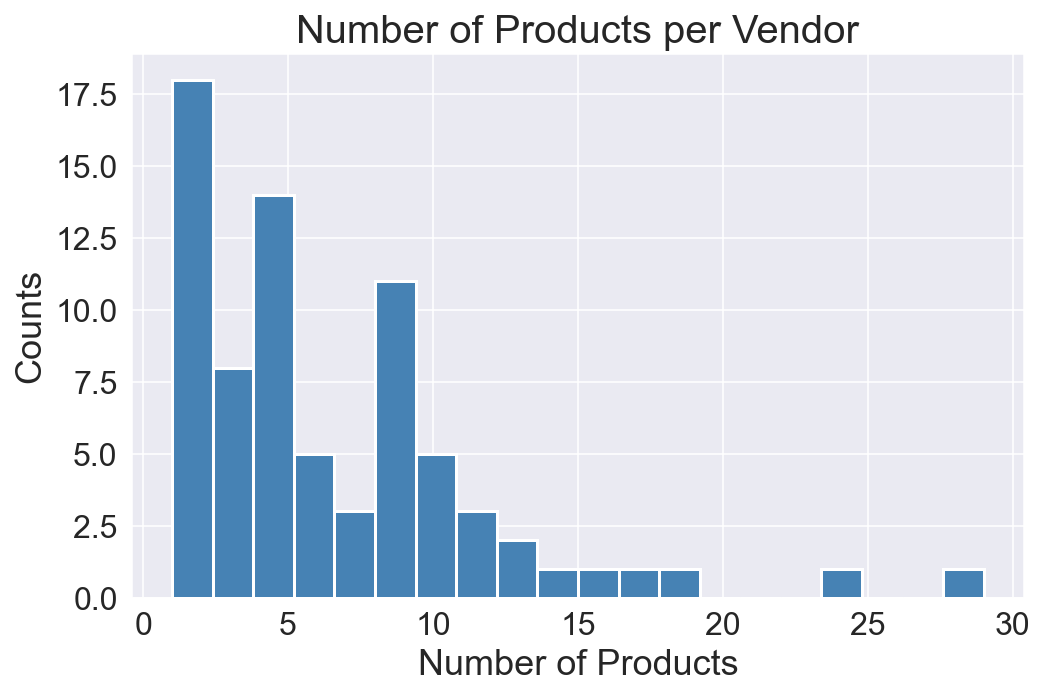

In [17]:
df['Vendor_id'].value_counts().hist(figsize=(8, 5),
                          bins=20,
                          color='steelblue',
                          linewidth=1.5);
plt.title('Number of Products per Vendor')
plt.xlabel('Number of Products')
plt.ylabel('Counts')

In [18]:
df['Country'].value_counts()

TW    487
IT      1
Name: Country, dtype: int64

In [19]:
df.drop(columns = 'Country', inplace = True)

## Categorical variable

In [20]:
df['Main_Category'].value_counts()

agritech                        280
agrilivestock                   116
agrifresh                        53
sustainable-aquatic-products     25
fish-farming                     14
Name: Main_Category, dtype: int64

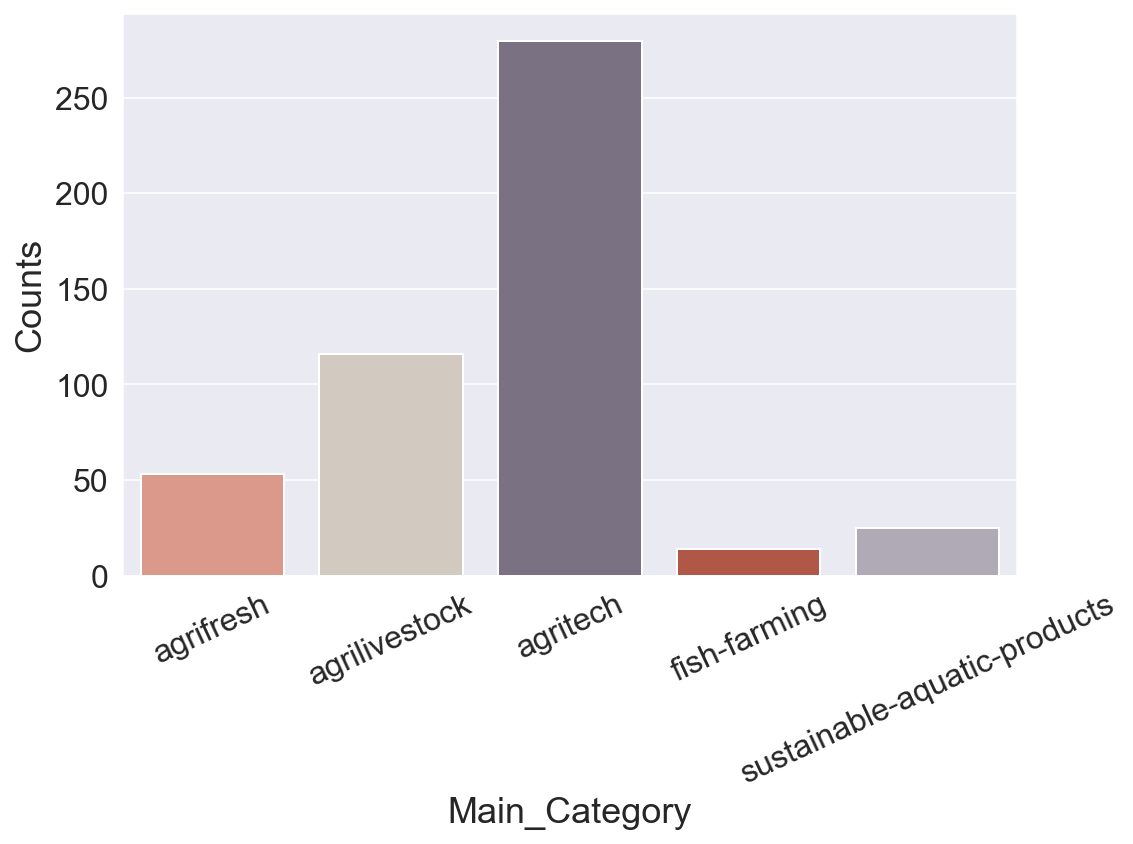

In [21]:
fig, ax = plt.subplots(figsize=(8, 6))
sns.countplot(x='Main_Category', data=df, palette=colors_cat, width=0.8)
plt.ylabel('Counts')
plt.xticks(rotation=25)
plt.tight_layout();

For certain subgroups, there are only a few products.

In [22]:
df['Sub_Category'].value_counts()

Agritech-Other                                           129
Agrilivestock-Other                                       50
Labour-Saving-Machinery-and-Equipment                     40
Livestock-Feed-and-Additives                              37
Garden-Materials                                          29
Sustainable-Aquatic-Products-Other                        24
Intelligent-Detection-System-and-Equipment                23
Ventilation-Equipment                                     21
Organic-Fertilizer                                        15
Agrifresh-Other                                           13
Agricultural-Processing-Machinery                         12
Seedlings-and-Flower-Seed                                 11
Plant-Disease-and-Pest-Control                            11
AIoT-Intelligent-Cold-Chain-Logistic-Solution             10
Refrigeration-and-Freezing-Equipment                      10
Fish-Farming-Other                                         9
Intelligent-Temperature-

## Text Description

In [23]:
df['Description'].head()

0    ●全天候環保聚乙烯膠帶\n \n ●高粘合溶劑型丙烯酸粘合劑 \n \n ●適用於大範圍的戶...
1    ● C+通用型包裝膠帶\n \n ●全世界第一個生物可分解OPP 包裝解決方案，可與一般PP...
2    ●軟質亮面PVC 膠帶\n \n ●高剝離力\n \n ●適合用於梨子接枝 \n \n ●環...
3                             軟質亮面PVC 膠帶、高剝離力、適合用於梨子接枝
4                             高黏著力、無溶劑、環境友善、高保持力、高機械強度
Name: Description, dtype: object

In [24]:
df['Description_en'].head()

0    ●All-weather environmentally friendly polyethy...
1    ● C+ general purpose packing tape\n \n ●The wo...
2    ●Soft and glossy finished PVC tape\n \n ●High ...
3    Soft and glossy finished PVC tape、High unwindi...
4    Strong Adhesion、Solvent-Free、ECO-Friendly、Heav...
Name: Description_en, dtype: object

# Data Preprocessing

We will create four embeddings:

* Main Category embedding 
* Subcategory embedding 
* Product Name embedding (tw)
* Product Name embedding (en)
* Product Description embedding (tw)
* Product Description embedding (en)

To generate accurate recommendation, we determine the weights of these embeddings based on their importance.

In [173]:
arr = [1, 4, 1, 25, 1, 13]
alpha = arr/np.sum(arr)

## Categorical Features Encoding

Utilize one-hot encoding to encode the `Main_Category` and `Sub_Category` variables, enabling us to analyze the similarity between vectors in the further analysis

In [175]:
main_encode = pd.get_dummies(df['Main_Category'], drop_first=False)*alpha[0]
sub_encode = pd.get_dummies(df['Sub_Category'], drop_first=False)*alpha[1]
category_encode = np.concatenate((main_encode, sub_encode), axis=1)
category_encode.shape

(488, 36)

## Text Encoding

Utilize Sentence-BERT, which is based on Siamese BERT-Networks, to generate embeddings for both `Product_Name` and `Description`, as described in the paper ["Sentence-BERT: Sentence Embeddings using Siamese BERT-Networks"](https://arxiv.org/pdf/1908.10084.pdf) (Reimers & Gurevych, 2019).

Change English product name into lowercase to have a consistent structure

In [293]:
df['Product_Name_en'] = df['Product_Name_en'].apply(lambda x: x.lower())

In [341]:
model_en = SentenceTransformer('all-mpnet-base-v2')
model_tw = SentenceTransformer('paraphrase-distilroberta-base-v1')
product_em_tw_ = model_tw.encode(df['Product_Name'])
product_em_en_ = model_en.encode(df['Product_Name_en'])
des_em_tw_ = model_tw.encode(df['Description'])
des_em_en_ = model_en.encode(df['Description_en'])

Normalize the embeddings to mitigate the influence of magnitude on similarity

In [342]:
product_em_tw = normalize_embedding(product_em_tw_) * alpha[2]
product_em_en = normalize_embedding(product_em_en_) * alpha[3]
des_em_tw = normalize_embedding(des_em_tw_) * alpha[4]
des_em_en = normalize_embedding(des_em_en_) * alpha[5]

In [367]:
keywords_en_em = np.concatenate((product_em_en, des_em_en), axis = 1)

In [344]:
# product_em = np.concatenate((product_em_tw, product_em_en), axis=1) * alpha[2]
# des_em = np.concatenate((des_em_tw, des_em_en), axis=1)  * alpha[3]
# text_em = np.concatenate((product_em, des_em), axis=1)

In [345]:
text_em = np.concatenate((product_em_en, des_em_en, product_em_tw, des_em_tw), axis=1)
text_em.shape

(488, 3072)

Combine category embedding and text embedding

In [346]:
embedding = np.concatenate((category_encode, text_em), axis=1)
embedding.shape

(488, 3108)

In [347]:
df.loc[1:100,['Product_Name','Product_Name_en','Description_en']]

,Product_Name,Product_Name_en,Description_en
1,C+ 生物可分解膠帶,c biodegradable tape,● C+ general purpose packing tape\n \n ●The wo...
2,PVC 接梨膠帶,pvc pear tape,●Soft and glossy finished PVC tape\n \n ●High ...
3,PVC 接梨膠帶,pvc pear tape,Soft and glossy finished PVC tape、High unwindi...
4,回收PET膠帶,recycled pet tape,Strong Adhesion、Solvent-Free、ECO-Friendly、Heav...
5,環保型牛皮紙膠帶,eco-friendly kraft tape,Writable、Solvent-Free、Good echanical\n \n Prop...
6,回收PET 水膠 膠帶,recycled pet water adhesive tape,●Good adhesion to paper fibers.\n \n ●Applicat...
7,水簾片,evaporative cooling pad,"In animal husbandry, it can lower the ambient ..."
8,紙護角,edgeboard,"Edgeboard, also known as corner board or angle..."
9,水簾片,evaporative cooling pad,There are several advantages to using evaporat...
10,水簾片,evaporative cooling pad,"Evaporative cooling pad, also known as wet pad..."


In [376]:
eb = normalize_embedding(model_en.encode('tape'))
eb = np.concatenate((eb, eb), axis = 0)
row_idx = []
score_ls = []
rec_k_dic = util.semantic_search(eb, keywords_en_em, top_k=10)[0]
for item in rec_k_dic:
    row_idx.append(item['corpus_id'])
    score_ls.append(round(item['score'],3))
df.loc[row_idx,['Product_id','Product_Name']]
score_ls

[0.501, 0.492, 0.477, 0.467, 0.425, 0.396, 0.36, 0.337, 0.322, 0.312]

In [374]:
keywords_en_em_dict

{'CU0004601801': array([-0.00068238, -0.0008351 , -0.00057515, ..., -0.00085073,
        -0.0004666 , -0.0016253 ], dtype=float32),
 'CU0004601802': array([ 0.00287817, -0.00143743,  0.00029558, ..., -0.00112786,
        -0.00099049, -0.00074643], dtype=float32),
 'CU0004601803': array([ 0.0005216 , -0.00198385, -0.00075828, ..., -0.00085053,
        -0.00041225, -0.00050907], dtype=float32),
 'CU0004601804': array([ 5.2160467e-04, -1.9838545e-03, -7.5827766e-04, ...,
        -7.2003872e-04,  7.9805031e-05, -6.3627987e-04], dtype=float32),
 'CU0004601805': array([ 0.00322652,  0.00333009,  0.00100012, ..., -0.00015489,
         0.00072367, -0.00092445], dtype=float32),
 'CU0004601806': array([ 0.00014453,  0.00187215,  0.00038585, ..., -0.00074207,
         0.00036482, -0.00045842], dtype=float32),
 'CU0004601807': array([ 0.00298562,  0.00395903,  0.00111975, ...,  0.00022692,
        -0.00200189,  0.00013228], dtype=float32),
 'CU0106080601': array([-0.00020665, -0.00799559,  0.00041

In [349]:
# diff = product_em_en_[4] - eb
# print('Norm:',np.linalg.norm(diff))

In [350]:
# x = np.arange(0, len(product_em_tw[0]))
# # Create the figure and subplots
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# # Plot the scatter plot on the first subplot
# diff = product_em_tw[0] - product_em_en[0]
# ax1.scatter(x, np.abs(diff), s=3)
# ax1.set_xlabel('X')
# ax1.set_ylabel('Absolute Difference')
# ax1.set_title('Scatter Plot of Absolute Difference')

# # Plot the scatter plots on the second subplot
# ax2.scatter(x, product_em_tw[0], s=3, label='Product TW')
# ax2.scatter(x, product_em_en[100], s=3, label='Product EN')
# ax2.set_xlabel('X')
# ax2.set_ylabel('embedding value')
# ax2.set_title('Scatter Plots of TW embedding and EN embedding of Product Name')
# ax2.legend()

# # Adjust the spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()

In [305]:
# # Create the figure and subplots
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# diff = np.abs(product_em_tw[0] - product_em_en[0])
# # Plot the scatter plot on the first subplot
# ax1.scatter(x, diff, s=3)
# ax1.set_xlabel('X')
# ax1.set_ylabel('Absolute Difference')
# ax1.set_title('Scatter Plot of Absolute Difference')

# # Plot the scatter plots on the second subplot
# ax2.scatter(x, product_em_tw[0], s=3, label='Product TW')
# ax2.scatter(x, des_em_tw[0], s=3, label='Product EN')
# ax2.set_xlabel('X')
# ax2.set_ylabel('embedding value')
# ax2.set_title('Scatter Plots of TW embedding and EN embedding of Product Name')
# ax2.legend()

# # Adjust the spacing between subplots
# plt.tight_layout()

# # Show the plot
# plt.show()

## Store embedding as a dictionary type in the file

Map the embedding to the corresponding product_id in a dictionary structure and store it

In [306]:
keys = df['Product_id']
# embedding = torch.tensor(embedding)
id_embedding_dict = dict(zip(keys, embedding))
file_name = '.\embedding\item_embedding.pkl'
with open(file_name, "wb") as file:
    pickle.dump(id_embedding_dict, file)

In [307]:
product_em_en_dict = dict(zip(keys, product_em_en))
    
file_name = '.\embedding\product_em_en.pkl'
with open(file_name, "wb") as file:
    # Serialize and write the dictionary to the file
    pickle.dump(product_em_en_dict, file)

In [308]:
des_em_en_dict = dict(zip(keys, des_em_en))
    
file_name = '.\embedding\des_em_en.pkl'
with open(file_name, "wb") as file:
    # Serialize and write the dictionary to the file
    pickle.dump(des_em_en_dict, file)

In [368]:
keywords_en_em_dict = dict(zip(keys, keywords_en_em))
    
file_name = '.\embedding\keywords_en_em.pkl'
with open(file_name, "wb") as file:
    # Serialize and write the dictionary to the file
    pickle.dump(keywords_en_em_dict, file)

Load the dictionary of embedding

In [309]:
# file_name = '.\embedding\item_embedding.pkl'
# with open(file_name, "rb") as file:
#     id_embedding_dict = pickle.load(file)

# Recommendation Model Building

## Experiment and Parameter Tuning

Sample items in each category to evaluate

In [32]:
# idx_list = []
# for colname in df['Sub_Category'].unique():
#     condition = df['Sub_Category'] == colname
#     idx = df[condition].sample(n=1).index[0]
#     idx_list.append(idx)
    
# sample_df = df.iloc[idx_list].drop(columns=['Product_id','Vendor_id','Country'])

Use all items to evaluate

In [253]:
idx_list = np.arange(0, df.shape[0])

Recommend items by calculating the cosine similarity between the item embeddings. Output the results into a cell file and save them in an Excel file.

In [254]:
output_file = './Data/Rec-Agr-{}.xlsx'.format(arr)
blank_row_color = 'FFFF00'  # Yellow color code

# Load the existing workbook or create a new one
try:
    workbook = openpyxl.load_workbook(output_file)
except FileNotFoundError:
    workbook = openpyxl.Workbook()

# Save the workbook
workbook.save(output_file)

# Get the default sheet name (usually "Sheet1")
sheet_name = workbook.sheetnames[0]

# Create a Pandas Excel writer using openpyxl engine and append mode
writer = pd.ExcelWriter(output_file, engine='openpyxl', mode='a')

# Assign the existing workbook to the writer
writer.book = workbook

# Select the default sheet
writer.sheets = {sheet_name: workbook[sheet_name]}

# Keep track of the row index for writing data
current_row = writer.sheets[sheet_name].max_row + 1

# Generate recommendations for each sample index
for sample_idx in idx_list:
    row_idx = []
    score_ls = []
    rec_k_dic = util.semantic_search(embedding[sample_idx], embedding, top_k=10)[0]
    for item in rec_k_dic:
        row_idx.append(item['corpus_id'])
        score_ls.append(round(item['score'],3))  
#     select_idx = np.insert(row_idx, 0, sample_idx) # Put the input item as a reference
    output_df = df.iloc[row_idx]
    output_df['Score'] = score_ls

    # Set the cell color for the first row behind the blank row
    sheet = writer.book[sheet_name]
    for col in range(1, len(output_df.columns) + 10):
        cell = sheet.cell(row=current_row + 1, column=col)
        cell.fill = openpyxl.styles.PatternFill(fill_type='solid', fgColor=blank_row_color)

    # Write the DataFrame to Excel
    output_df.to_excel(writer, sheet_name=sheet_name, startrow=current_row, index=True, header=False)

    # Update the current row index for the next set of recommendations
    current_row += len(output_df) + 1  # Add 1 for the blank row

# Save the Excel file
writer.save()
workbook.close()
writer.close()

<ipython-input-254-a53aeef176c1>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  output_df['Score'] = score_ls


## Recommend Top K

In [78]:
# product_id = 'CU0004601801' # tape
# product_id = 'CU0009108101' # alcohol
# product_id = 'CU0004414408' # thermometer
product_id = 'CU0001452809'

k = 5
threshold = 0.75
row_index = df[df['Product_id'] == product_id].index
df.iloc[row_index]

,Product_id,Product_Name,Vendor_id,Main_Category,Sub_Category,Description,Product_Name_en,Description_en
262,CU0001452809,正壓風機,CU00014528,agrilivestock,Ventilation-Equipment,1.環保節能+舒適安全\n \n 2.保護環境+造福勞工\n \n 3.提高工作效率提高產能...,Fan,1.Environment control and saving energy.\n \n ...


In [33]:
rec_pd_id_ls, rec_score_ls, rec_row_idx = recommend_top_k(product_id, k, 0.75)
for i in range(len(rec_pd_id_ls)):
    print('Product_id:', rec_pd_id_ls[i],'Score:', rec_score_ls[i])
df.iloc[rec_row_idx]

Product_id: CU0009108102 Score: 0.811
Product_id: CU0009108107 Score: 0.807
Product_id: CU0009108106 Score: 0.796
Product_id: CU0009108115 Score: 0.781
Product_id: CU0009108109 Score: 0.78


,Product_id,Product_Name,Vendor_id,Main_Category,Sub_Category,Description,Product_Name_en,Description_en
17,CU0009108102,時氣純韻(糙米白酒),CU00091081,sustainable-aquatic-products,Sustainable-Aquatic-Products-Other,天癒糙米淬釀而成，純米風味，口感温順。(32%),Viachi Spirit – Longevity (Brown Rice),"Made from Viachi brown rice, it is pleasantly ..."
22,CU0009108107,和氣元酒(丹參),CU00091081,sustainable-aquatic-products,Sustainable-Aquatic-Products-Other,介紹：天癒醲系列經典代表作。天癒丹參高純度產製，蔘味醇厚，豪氣順喉。鮮採後，輔以獨特製酒技術...,Viachi Spirit – The Dove (Salvia),Introduction：\n \n Grown in the AgriDragon Bio...
21,CU0009108106,福氣永豐(葡萄酒),CU00091081,sustainable-aquatic-products,Sustainable-Aquatic-Products-Other,天癒巨峰葡萄醇釀，濃烈豐厚，温潤純粹，值得品味珍藏。 \n \n 無添加人工香料及食用酒精\...,Viachi Spirit – Abundance (Grape),Made from healthy grapes cultivated using the ...
30,CU0009108115,天癒花草茶,CU00091083,sustainable-aquatic-products,Sustainable-Aquatic-Products-Other,純淨天然放鬆‧舒緩‧平和\n 內容物：\n 檸檬香蜂草、巧克力薄荷、綠薄荷、檸檬馬鞭草、甜菊...,Viachi Herbal Tea,"100% Pure & Natural\n \n Relaxing, Calming, an..."
24,CU0009108109,天癒丹參勁花茶,CU00091081,sustainable-aquatic-products,Sustainable-Aquatic-Products-Other,介紹：以多項專利天癒仿生科技農法栽培之高品質原樣態素材：丹參莖、葉用枸杞、甜菊葉及馬郁蘭莖葉...,Viachi Energizing Herbal Tea,nIntroduction：\n \n Consisting of Salvia Milti...


# Future Development

- How can the performance and accuracy of the recommendation model be evaluated and measured in the context of the exhibition industry, considering the absence of explicit labels?
- Overall, the recommendations are generally accurate. However, the model occasionally generates some irrelevant items for specific products.


# Conclusions

The expected outcome is an item-based recommendation model for the dynamic exhibition industry that significantly enhances attendees' ability to find relevant products efficiently. By addressing the difficulties related to unsupervised learning, lack of quantitative features, and reliance on text information, the model aims to identify key product features, effectively utilize them for recommendations, and employ suitable similarity analysis techniques. Through these methods, the model strives to provide accurate and relevant recommendations, improving the overall experience for attendees.